[**COLAB LINK**](https://colab.research.google.com/drive/1_5Yem4IRId-2HuSDSFMrgW2Drb91FwJh)

# **Lab 6: Differential Equations**
**Edvin von Platen**

# **Abstract**

In this lab we implement and evaluate different time stepping methods for solving some differential equations. Implemented methods are:

- Implicit Euler for scalar initial value problems (IVP).
- Heuns method for system of IVPs.
- Euler-Maruyama mnethod for scalar stochastic differential equations.

The implementation of the methods appear to be sound and they perform as expected.

#**About the code**

In [0]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Edvin von Platen (edvinvp@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**
In this lab we implement and evaluate different time stepping methods for the approximation of the initial value differential equation,
\begin{align}
\dot{u}(t) &= f(u(t),t), \ \ 0 < t \leq T \\
u(0) &= u_0.
\end{align}
We implement methods for both scalar and systems of IVPs, and for stochastic IVPs where $f(u(t), t)$ is stochastic.

All material referenced are from the course [DD2363 Methods in Scientific Computing](https://kth.instructure.com/courses/17068) lecture notes.

# **Methods**

### **Time Stepping for Scalar IvP: Implicit Euler**
The implicit Euler method is the Theta method,
$$
U_n = U_{n-1} + k_n\left( (1-\Theta)f(U_n, t_n) + \Theta f(U_{n-1}, t_{n-1})\right),
$$
with $\Theta = 0$. This means that for any non-linear function $f$ we have to solve the equation,
$$
x = U_{n-1} + k_nf(x, t_n).
$$
We use Newton's method, let
$$
h(x) = U_{n-1} + k_nf(x, t_n) - x, \ h'(x) = k_n f'(x,t_n) - 1,
$$
$h$ and $h'$ is then used as input to Newton's method each iteration.

In [0]:
def newton_scalar(f,f_prim,start, TOL):
  x = start
  while abs(f(x)) > TOL:
    x = x - f(x)/f_prim(x)
  return x

def implicit_euler(f, f_prim, u_0, T, N):
  k = T/N
  steps = np.zeros(N)
  u = np.zeros(N)
  u[0] = u_0
  for i in range(1,N):
    u_prim = lambda x: k*f_prim(x,k*i) - 1
    u_func = lambda x: u[i-1] + k*f(x, k*i) - x
    u[i] = newton_scalar(u_func, u_prim, u[i-1], 0.00001)
    steps[i] = k*i
  return u, steps

### **Time Stepping for a a System of IvP's: Heuns Method**

Time stepping methods for a system of IvP's are almost identical to the scalar case. We want to find a vector function $u: [0,T]\to R^N$ such that for $f:R^N \times [0,T]  \to R^N$ and by (14.1),
\begin{align}
\dot{u}(t) &= f(u(t),t), \ \ 0 < t \leq T \\
u(0) &= u_0.
\end{align}
Where $u_0$ is the initial value  of the IvP.

We implement Heuns method which is a predictor corrector method that uses explicit Euler for the prediction step and the trapezoidal rule for the correction step. The trapezoidal rule is the $\Theta$-method with $\Theta = 0.5$.




In [0]:
def Heuns_Method(f, var_count, u_0, T, N):
  k = T/N
  steps = np.zeros(N)
  u = np.zeros((var_count, N))
  u[:,0] = u_0
  for i in range(1,N):
    # Prediction: Explicit Euler Step
    EE = u[:,i-1] + k*f(u[:,i-1], k*(i-1))
    # Correction: Trapezoidal step
    u[:,i] = u[:,i-1] + k*( (1/2)*f(u[:,i-1], k*(i-1)) + (1/2)*f(EE, k*i))
    steps[i] = k*i
  return u, steps

### **Simulation of a Trajectory of a Stochastic Differential Equation: $d X_t =  \mu X_t dt + \sigma X_t dW$**



We can express an IvP in differential form as,
$$
du(t) = f(u(t), t)dt, \ \ u(0) = u_0.
$$
For a stochastic differential equation (SDE) (Section 13.6) there is a stochastic part of $f(u(t), t)$,
$$
f(u(t), t) = \mu(u(t), t)  + \sigma(u(t),t) \xi_t,
$$
where $\{\xi\}$ is known as a white noise stochastic process, defined by $d W_t = \xi_t dt$ where $d W_t \sim N(0,dt)$, $W_t$ is known as the Wiener process.

This means that we want to find a stochastic process $X_t$ such that,
$$
d X_t = \mu(X_t, t)dt  + \sigma(X_t,t) d W_t, \ \ P(X_0 = u(0)) = 1,
$$
whcih we can write in integral form as,
$$
X_t = X_0 + \int_0^t \mu (X_s, s) ds + \int_0^t \sigma(X_s, s) dW_s.
$$

To approximate a solution of one observation (path), of $X_t$ we can use the Euler-Maruyama method,
\begin{align*}
x_0 &= u(0), \\
x_n &= x_{n-1} + \mu (x_{n-1}, t_{n-1}) \Delta t_n + \sigma (x_{n-1}, t_{n-1}) \Delta W_n, \\
\Delta t_n &= t_n - t_{n-1}, \\
 \Delta W &= W_{t_n} - W_{t_{n-1}} = Z \sqrt{\Delta t_n}, \ Z \sim N(0,1).
\end{align*}
Since this only approximates one path we can approximate the expected value by the mean of several paths due to the law of large numbers.

In [0]:
def Euler_Maruyama(mu, sigma, u_0, T, N):
  dt = T/N
  steps = np.zeros(N)
  u = np.zeros(N)
  u[0] = u_0
  Z = np.random.normal(0, 1, N)
  for i in range(1,N):
    u[i] = u[i-1] + dt*mu(u[i-1], dt*(i-1)) + sigma(u[i-1], dt*(i-1))* Z[i-1]*np.sqrt(dt)
    steps[i] = i*dt
  return steps, u

# **Results**

### **Time Stepping for Scalar IvP: Implicit Euler**
We test our implementation by (1) accuracy, and (ii) stability with respcet to linear model problem $\frac{du}{dt} = au, \ \ a \in R, \ a < 0$.

We use the linear problem,
$$
\frac{du}{dt} = -2u, \ \ u_0 = 1.
$$
which has one equilibrium point $u^*= 0$ and solution,
$$
u(t) = e^{-2t}.
$$
From Section 13.3 we know that the equilibrium point is stable since $\lambda = -2 < 0$, and that the solver should converge to $u(t)=0$.

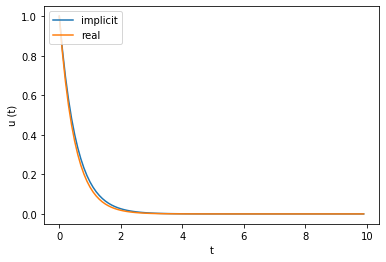

In [0]:
 f = lambda u, t: -2*u
f_prim = lambda u, t: -2
r_real = lambda t: np.exp(-2*t)

u, steps = implicit_euler(f, f_prim, 1, 10, 100)
plt.plot(steps, u, label="implicit")

vals = list(map(r_real, steps))
plt.plot(steps, vals, label="real")
plt.legend(loc="upper left")
plt.xlabel("t")
plt.ylabel("u (t)")
plt.show()

The implicit Euler implementation appear to be accurate and the solution converges to the equilibrium point.

### **Time Stepping for a a System of IvP's: Heuns Method**
We test the Heuns method implementation with the Volterra-Lotka (Example 14.11) equation. The equation model a predator-prey system of two species (14.10):
$$
\begin{pmatrix}
\dot{u}_1(t) \\
\dot{u}_2(t) \\
\end{pmatrix} = 
\begin{pmatrix}
u_1(t)(\alpha - \beta u_2(t)) \\
u_2(t)(\delta u_1 - \gamma)\\
\end{pmatrix}
$$
where $u_1$ is the prey and $u_2$ the predator, with $\alpha, \beta, \delta, \gamma > 0$. It is shown in Example (14.11) that there exists two equilibrium points, $u_1^* = (0,0)$ and $u_2^* = \left( \frac{\gamma}{\delta}, \frac{\alpha}{\beta}\right)$. Where, $u_1^*$ is unstable (both species vanish) and the solution will oscilate around $u_2^*$.

We replicate Figure 14.4 for $(\alpha, \beta, \gamma, \delta) = (1,1,2,1.5)$ and $u_0 = (1.1,0.5)$. Using a time evolution Figure and a corresponding phase diagram, the equilibrium point is $(2/1.5, 1)$,

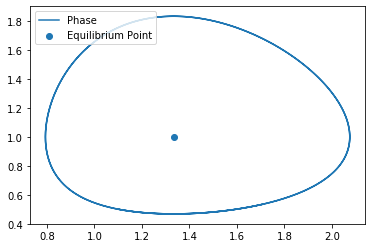

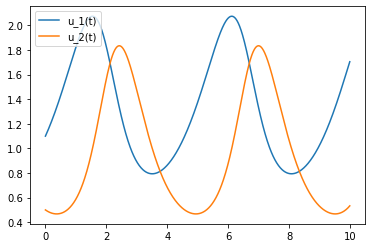

In [0]:
tst = lambda u, t: np.array([u[0] * (1-1*u[1]), u[1] * (1.5*u[0] - 2)])

u, steps = Heuns_Method(tst, 2, np.array([1.1,0.5]), 10, 1000)
plt.plot(u[0,:], u[1,:], label = "Phase")
plt.scatter(2/1.5, 1, label = "Equilibrium Point")
plt.legend(loc="upper left")
plt.show();

plt.plot(steps, u[0,:], label="u_1(t)")
plt.plot(steps, u[1,:], label="u_2(t)")
plt.legend(loc="upper left")
plt.show();

The two Figures apear to be identical to Figure 14.4.

### **Simulation of a Trajectory of a Stochastic Differential Equation: $d X_t =  \mu X_t dt + \sigma X_t dW$**

To test our Euler-Maruyama implementation we use the Ornstein-Uhlenbeck process (Example 13.9) which models Brownian motion with friction by,
$$
dX_t = -\mu X_t dt + \sigma dW_t, \ \ \mu > 0, \sigma > 0.
$$
Which has an expected value of,
$$
E(X_t) = X_0 e^{-\mu t}.
$$
We use the values,
$$
\mu = 0.5, \ \sigma = 0.3, \ \ X_0 = 10, \ t = 10.
$$
Which gives us the expected value at $t=10$,
$$
E(X_{10}) = 10e^{-5} \approx 0.06737947.
$$
The expected value is approximated from the law of large numbers by simulating $10000$ trajectories, every $500th$ trajectory is plotted.

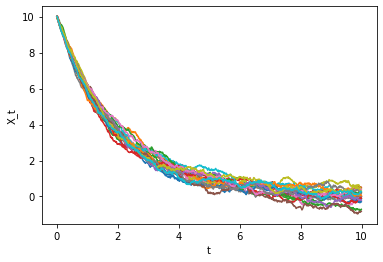

E(X_{10}) approx 0.6804010006409491


In [0]:
ou_mu = lambda u, t: -0.5*u
ou_sigma = lambda u, t: 0.3
mean = 0
for i in range(10000):
  steps, u = Euler_Maruyama(ou_mu, ou_sigma, 10, 10, 1000)
  if (i % 500 == 0):
    plt.plot(steps, u)
  mean += u[999]
plt.xlabel("t")
plt.ylabel("X_t")
plt.show()
print("E(X_{10}) approx " + str(mean / 1000))

The approximation appears to be quite close.

# **Discussion**

The three implementations appear to be correct and we could replicate some results from the lecture notes. 

It is quite surprising how simple the time stepping algorithms are, given how difficult the problems are to solve analytically. However, the diffucult part is most likely analyzing the stability of the equation and the error of the solution. 